# Milliken Moment Diagram Analysis

Importing necessary libraries

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import magic_moment_method.vehicle_params as vehicle_params
import magic_moment_method.state_solver as state_solver
from magic_moment_method.solver_sweeper import solver_sweeper
import labellines

In [4]:
mesh = 21 # NOTE: MAKE SURE THIS IS ODD

# NOTE: guesstimation based from TTC on maximum tire saturation slip angle
sweep_range = {"body_slip": (-10 * np.pi / 180, 10 * np.pi / 180),
        "steered_angle" : (-20 * np.pi / 180, 20 * np.pi / 180),
        "velocity" : (3, 30),
        "torque_request": (-1, 1),
        "is_left_diff_bias": (True)}

body_slip_sweep = np.linspace(sweep_range["body_slip"][0], sweep_range["body_slip"][1], mesh)
steered_angle_sweep = np.linspace(sweep_range["steered_angle"][0], sweep_range["steered_angle"][1], mesh)
torque_sweep = np.linspace(sweep_range["torque_request"][0], sweep_range["torque_request"][1], mesh)

sweep_values = {"velocity": [12], "body_slip":body_slip_sweep, "steered_angle":steered_angle_sweep,
                 "torque_request": [0], "is_left_diff_bias" : [True, False]}


vehicle = vehicle_params.Concept2023(motor_directory="vehicle_params/Eff228.csv")

df = solver_sweeper(vehicle, sweep_values)

tires = ["front_left", "front_right", "rear_left", "rear_right"]

882it [00:11, 78.22it/s]


Import generated points & filter garbage points

MMD Plot (Note - this really doesnt work when you are sweeping velocities and torque requests)

Text(0.5, 1.0, 'Milliken Moment Method \n Blue -> Discrete Steered Angle (deg); Red -> Discrete Body Slip (deg)')

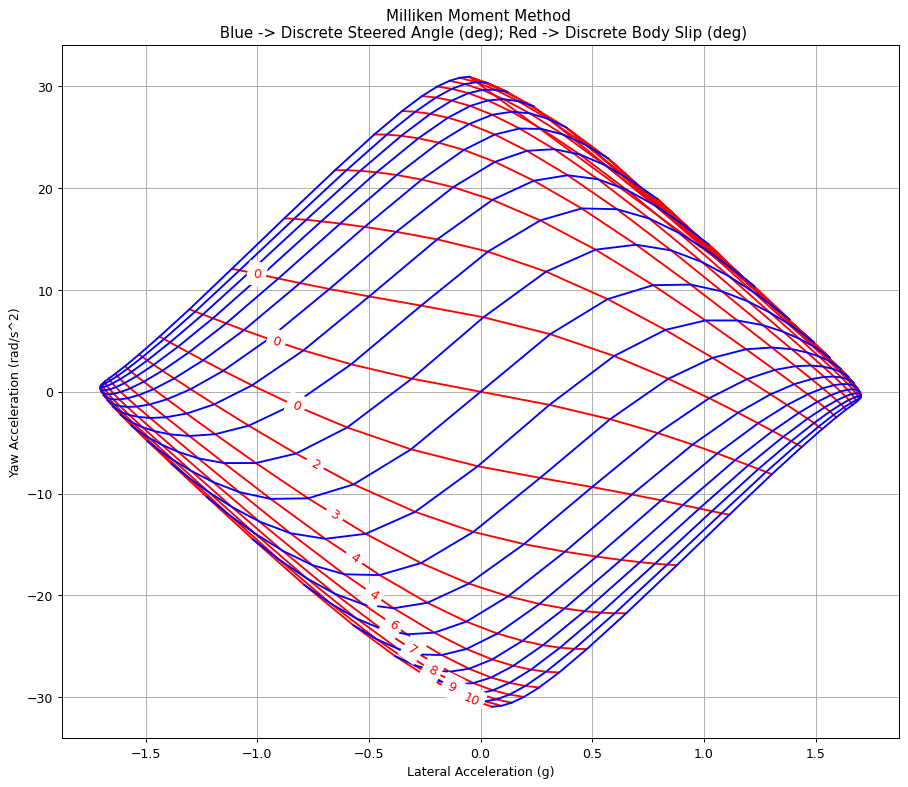

In [5]:
fig = plt.figure(figsize=(12, 10), dpi=90)
ax = fig.add_subplot(111)
mmm_df = df # df[abs(df["torque_request"]-0) < 0.01 ]
# mmm_df = df[(df["vehicle_accelerations_NTB_1"] > 0) & (df["is_left_diff_bias"] != False) | (df["vehicle_accelerations_NTB_1"] < 0) & (df["is_left_diff_bias"] != True)]
for x in mmm_df["body_slip"].unique():
    df2 = mmm_df[mmm_df["body_slip"] == x]
    plt.plot(df2["vehicle_accelerations_NTB_1"]/9.81, df2["yaw_acceleration"], 'r', label = int(x*180/np.pi))
#labellines.labelLines(plt.gca().get_lines(),zorder=2)

for x in mmm_df["steered_angle"].unique():
    df2 = mmm_df[(mmm_df["steered_angle"] == x)]
    plt.plot(df2["vehicle_accelerations_NTB_1"]/9.81, df2["yaw_acceleration"], 'b', label = int(x*180/np.pi))
labellines.labelLines(plt.gca().get_lines(),zorder=2)

#plt.scatter(df["vehicle_accelerations_NTB_1"]/9.81, df["yaw_acceleration"])

plt.grid()
plt.ylabel("Yaw Acceleration (rad/s^2)")

plt.xlabel("Lateral Acceleration (g)")
plt.title("Milliken Moment Method \n Blue -> Discrete Steered Angle (deg); Red -> Discrete Body Slip (deg)")

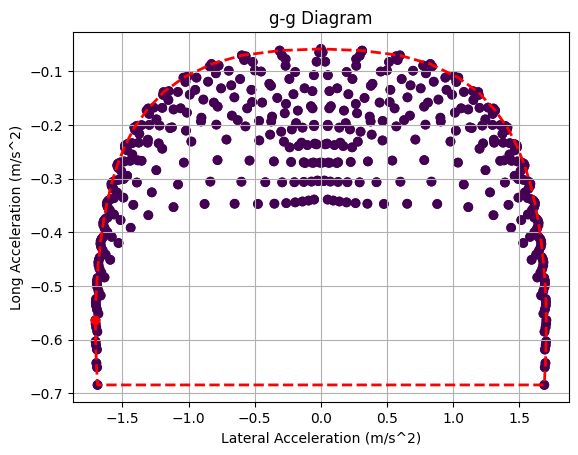

In [6]:
plt.scatter(df["vehicle_accelerations_NTB_1"]/9.81, df["vehicle_accelerations_NTB_0"]/9.81 , c=df["torque_request"],cmap="viridis")
plt.title("g-g Diagram")
plt.ylabel("Long Acceleration (m/s^2)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.grid()
from scipy.spatial import ConvexHull
points = df[["vehicle_accelerations_NTB_1","vehicle_accelerations_NTB_0"]].to_numpy()
hull = ConvexHull(points)
x = np.transpose(points)
plt.plot(points[hull.vertices,0]/9.81, points[hull.vertices,1]/9.81, 'r--', lw=2)
plt.plot(points[hull.vertices[0],0]/9.81, points[hull.vertices[0],1]/9.81, 'ro')
#plt.scatter(x[0], x[1])
plt.show()
new_df = df.iloc[hull.vertices]

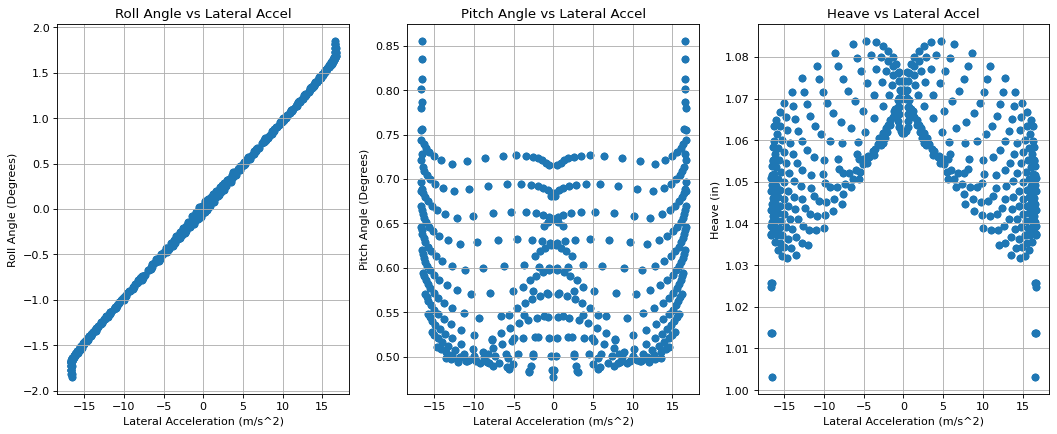

In [7]:
fig, axs = plt.subplots(1,3,figsize=(16, 6), dpi=80)

axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['roll'] * (180 / np.pi))
axs[0].set_xlabel("Lateral Acceleration (m/s^2)")
axs[0].set_ylabel('Roll Angle (Degrees)')
axs[0].set_title("Roll Angle vs Lateral Accel")
axs[0].grid()

axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['pitch'] * (180 / np.pi))
axs[1].set_xlabel("Lateral Acceleration (m/s^2)")
axs[1].set_ylabel('Pitch Angle (Degrees)')
axs[1].set_title("Pitch Angle vs Lateral Accel")
axs[1].grid()

axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['heave']/.0254)
axs[2].set_xlabel("Lateral Acceleration (m/s^2)")
axs[2].set_ylabel('Heave (in)')
axs[2].set_title("Heave vs Lateral Accel")
axs[2].grid()

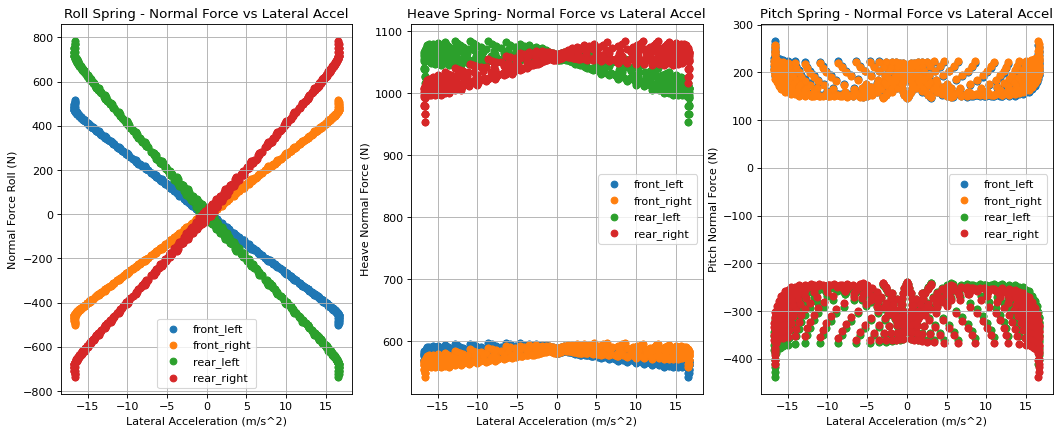

In [8]:
fig, axs = plt.subplots(1,3,figsize=(16, 6), dpi=80)

for tire in tires:
    axs[0].scatter(df["vehicle_accelerations_NTB_1"], df[f"{tire}_tire_f_roll"], label = tire)
axs[0].set_title("Roll Spring - Normal Force vs Lateral Accel")
axs[0].grid()
axs[0].set_ylabel("Normal Force Roll (N)")
axs[0].set_xlabel("Lateral Acceleration (m/s^2)")
axs[0].legend()

for tire in tires:
    axs[1].scatter(df["vehicle_accelerations_NTB_1"], df[f"{tire}_tire_f_heave"], label = tire)
axs[1].set_title("Heave Spring- Normal Force vs Lateral Accel")
axs[1].grid()
axs[1].set_ylabel("Heave Normal Force (N)")
axs[1].set_xlabel("Lateral Acceleration (m/s^2)")
axs[1].legend()

for tire in tires:
    axs[2].scatter(df["vehicle_accelerations_NTB_1"], df[f"{tire}_tire_f_pitch"], label = tire)
axs[2].set_title("Pitch Spring - Normal Force vs Lateral Accel")
axs[2].grid()
axs[2].set_ylabel("Pitch Normal Force (N)")
axs[2].set_xlabel("Lateral Acceleration (m/s^2)")
axs[2].legend()

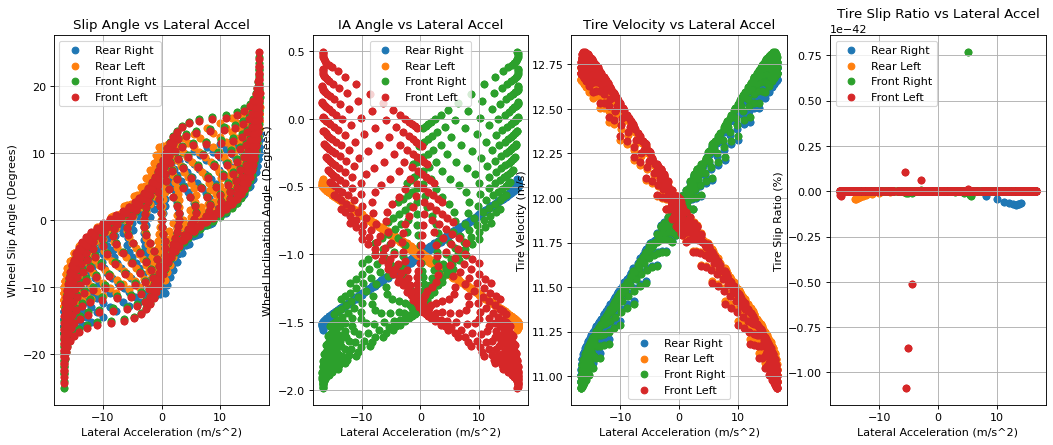

In [9]:
fig, axs = plt.subplots(1,4,figsize=(16, 6), dpi=80)

axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_slip_angle'] * (180 / np.pi), label='Rear Right')
axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_slip_angle'] * (180 / np.pi), label='Rear Left')
axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_slip_angle'] * (180 / np.pi), label='Front Right')
axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_slip_angle'] * (180 / np.pi), label='Front Left')
axs[0].legend()
axs[0].set_xlabel("Lateral Acceleration (m/s^2)")
axs[0].set_ylabel('Wheel Slip Angle (Degrees)')
axs[0].set_title("Slip Angle vs Lateral Accel")
axs[0].grid()

axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_inclination_angle'] * (180 / np.pi), label='Rear Right')
axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_inclination_angle'] * (180 / np.pi), label='Rear Left')
axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_inclination_angle'] * (180 / np.pi), label='Front Right')
axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_inclination_angle'] * (180 / np.pi), label='Front Left')
axs[1].legend()
axs[1].set_xlabel("Lateral Acceleration (m/s^2)")
axs[1].set_ylabel('Wheel Inclination Angle (Degrees)')
axs[1].set_title("IA Angle vs Lateral Accel")
axs[1].grid()

axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_velocity_0'], label='Rear Right')
axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_velocity_0'], label='Rear Left')
axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_velocity_0'], label='Front Right')
axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_velocity_0'], label='Front Left')
axs[2].legend()
axs[2].set_xlabel("Lateral Acceleration (m/s^2)")
axs[2].set_ylabel('Tire Velocity (m/s)')
axs[2].set_title("Tire Velocity vs Lateral Accel")
axs[2].grid()

axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_slip_ratio'], label='Rear Right')
axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_slip_ratio'], label='Rear Left')
axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_slip_ratio'], label='Front Right')
axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_slip_ratio'], label='Front Left')
axs[3].legend()
axs[3].set_xlabel("Lateral Acceleration (m/s^2)")
axs[3].set_ylabel('Tire Slip Ratio (%)')
axs[3].set_title("Tire Slip Ratio vs Lateral Accel")
axs[3].grid()

Text(0.5, 1.0, 'Turn Radius vs Lateral Accel (constant velocity)')

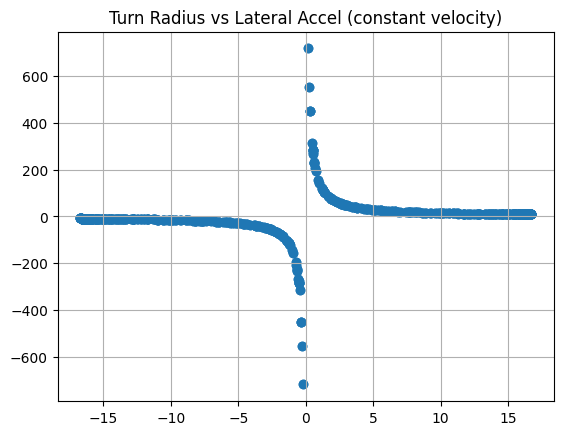

In [10]:
temp_df = df[abs(df["vehicle_turn_radius"]) < 1000]
plt.scatter(temp_df["vehicle_accelerations_NTB_1"],temp_df["vehicle_turn_radius"])
plt.grid()
plt.title("Turn Radius vs Lateral Accel (constant velocity)")

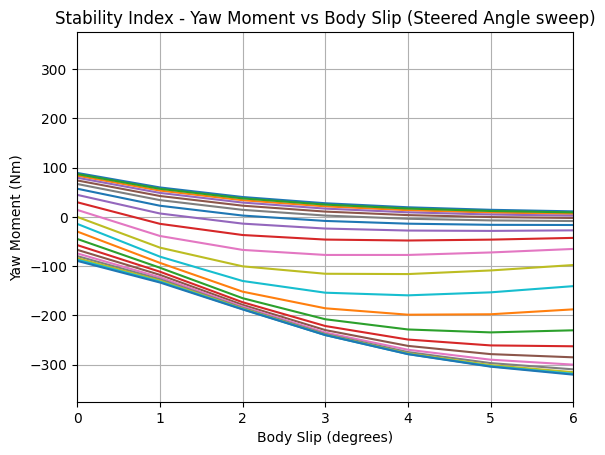

In [17]:
for x in mmm_df["steered_angle"].unique():
    df2 = mmm_df[(mmm_df["steered_angle"] == x)]
    plt.plot(df2["body_slip"] * 180/math.pi, df2["vehicle_yaw_moment"]/9.81)
plt.xlim([0, 6])
plt.title("Stability Index - Yaw Moment vs Body Slip (Steered Angle sweep)")
plt.ylabel("Yaw Moment (Nm)")
plt.xlabel("Body Slip (degrees)")
plt.grid(True)
plt.show()

Text(0.5, 0, 'Lateral Acceleration (m/s^2)')

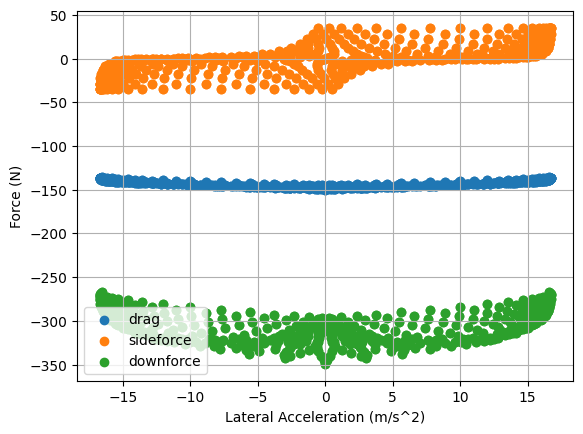

In [13]:
plt.scatter(df["vehicle_accelerations_NTB_1"],df["aero_forces_0"], label = "drag")
plt.scatter(df["vehicle_accelerations_NTB_1"],df["aero_forces_1"], label = "sideforce")
plt.scatter(df["vehicle_accelerations_NTB_1"],df["aero_forces_2"], label = "downforce")
plt.legend()
plt.grid()
plt.ylabel("Force (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")

Text(0.5, 1.0, 'Side Force vs Body Slip')

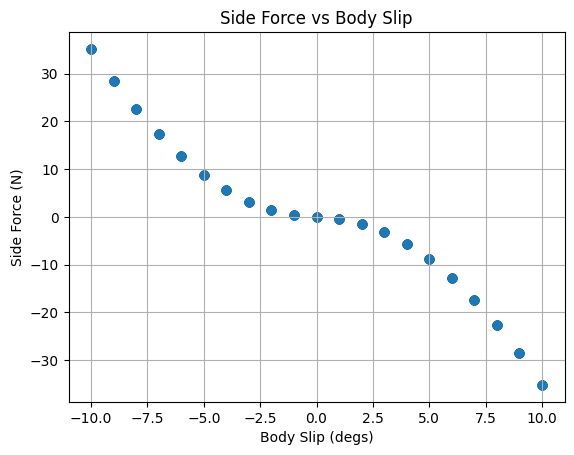

In [14]:
plt.scatter(df["body_slip"]*180/np.pi,df["aero_forces_1"], label = "sideforce")
plt.grid()
plt.ylabel("Side Force (N)")
plt.xlabel("Body Slip (degs)")
plt.title("Side Force vs Body Slip")